In [1]:
import pandas as pd
train_data = pd.read_excel("./train.xlsx")

In [2]:
from tqdm import tqdm
train_data_text = list(train_data['title'])

train_clear_text = []

for i in tqdm(range(len(train_data_text))):
  train_clear_text.append(train_data_text[i].replace('XXX', ''))
train_data['clear_text'] = train_clear_text

100%|██████████| 36729/36729 [00:00<00:00, 1475599.54it/s]


In [3]:
import re

train_clear_text = list(train_data['clear_text'])

train_clear_text2 = []

for text in train_clear_text:
  temp = re.sub('[-=+,#/\?:^$.@*\"※~>`\'…》]', '', text)
  train_clear_text2.append(temp)
train_data['clear_text2'] = train_clear_text2

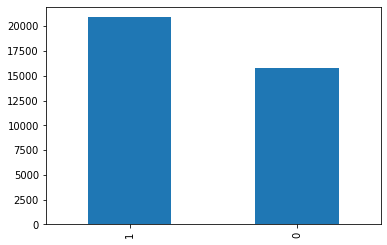

In [4]:
train_data['labeling'].value_counts().plot(kind='bar')

In [8]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 69.7MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
     |████████████████████████████████| 3.8MB 35.9MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [9]:
from konlpy.tag import Okt


In [10]:
okt = Okt()

In [11]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [12]:
from tqdm import tqdm
X_train = []

text = list(train_data['clear_text2'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = okt.morphs(text[i], stem=True) # 토큰화
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  X_train.append(temp_X)

100%|██████████| 36729/36729 [01:03<00:00, 574.68it/s]


In [13]:
from keras.preprocessing.text import Tokenizer
max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)


In [14]:
print(X_train[:3])

[[1023, 335, 414, 1023, 1775, 414, 632], [244, 9393, 415, 902, 252, 444, 124, 3282, 554, 4261, 728], [678, 769, 71, 22, 2255, 2524, 2622, 222, 633]]


문자의 최대 길이 : 26
문자의 평균 길이 :  8.018432301451169


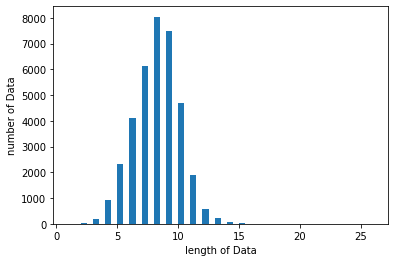

In [15]:
import matplotlib.pyplot as plt

print("문자의 최대 길이 :" , max(len(l) for l in X_train))
print("문자의 평균 길이 : ", sum(map(len, X_train))/ len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [16]:
len(train_data['labeling'])

36729

In [17]:
from keras.utils import np_utils
import numpy as np

y_train = []

for i in range(len(train_data['labeling'])):
  if train_data['labeling'].iloc[i] == 1:
    y_train.append([0, 1])
  elif train_data['labeling'].iloc[i] == 0:
    y_train.append([1, 0])

y_train = np.array(y_train)

In [18]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

In [19]:
max_len = 26 # 전체 데이터의 길이를 315로 맞춘다

X_train = pad_sequences(X_train, maxlen=max_len)


In [20]:
print(y_train.shape)
(X_train.shape)

(36729, 2)


(36729, 26)

In [30]:
model3 = Sequential()
model3.add(Embedding(max_words, 100))
model3.add(LSTM(128))
model3.add(Dense(2, activation='relu'))
model3.add(Dense(2, activation='sigmoid'))


model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)




Epoch 1/5
919/919 [==============================] - 33s 35ms/step - loss: 0.6881 - accuracy: 0.5526 - val_loss: 0.6705 - val_accuracy: 0.6352
Epoch 2/5
919/919 [==============================] - 33s 36ms/step - loss: 0.6338 - accuracy: 0.6292 - val_loss: 0.6934 - val_accuracy: 0.5636
Epoch 3/5
919/919 [==============================] - 32s 35ms/step - loss: 0.4899 - accuracy: 0.7663 - val_loss: 0.8220 - val_accuracy: 0.4995
Epoch 4/5
919/919 [==============================] - 32s 35ms/step - loss: 0.3383 - accuracy: 0.8472 - val_loss: 0.9561 - val_accuracy: 0.5054
Epoch 5/5
919/919 [==============================] - 33s 36ms/step - loss: 0.2201 - accuracy: 0.8952 - val_loss: 1.4466 - val_accuracy: 0.5029


KeyError: ignored

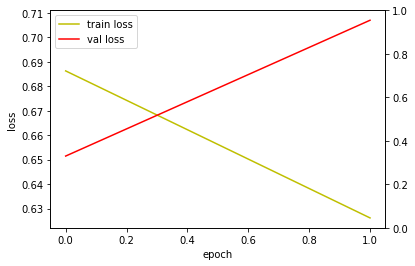

In [22]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history3.history['loss'], 'y', label='train loss')
loss_ax.plot(history3.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history3.history['acc'], 'b', label='train acc')
acc_ax.plot(history3.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()